# New York Airbnb Data Analysis
## CRISP-DM Process
### Business Understanding: 
From the Airbnb listings dataset for New York we can get a better understanding of how the rental prices vary based on the neighbourhood and property type. We can also figure out some interesting correlations between the host and review ratings and features that possibly affect these ratings. The listings data can be cleansed, preprocessed and modeled to predict useful information. The following business questions were asked before diving into the dataset:

1. How does the rental price vary based on property type and neighbourhood?
2. What factors contribute towards a host rating? What aspects could possibly help a host get a better rating?
3. How can we predict the rental price for a property?
4. How can we predict if a host is qualified to be a superhost?
5. Based on the host ratings and ammenities offered, how can we predict review score rating for a listing?

### Data Understanding：
New York Airbnb dataset has ---- listings. Datasets were investigated before any preprocessing.

### Data Preparation: 
Including data cleaning, filling NAN value, one-hot encoding and MinMax preprocessing.

### Data Modeling: 
Used Liner Regression model for training.

### Evaluating the Results: 
Results and discussions are published in (Link to medium blog)

##### DONE WITH ALL IMPORTS ###### 





/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##### DONE WITH CSV IMPORT ###### 



Number of Columns after dropping unwanted cols are:  76



Columns with No Nulls are:  {'instant_bookable', 'maximum_minimum_nights', 'maximum_maximum_nights', 'country', 'minimum_nights_avg_ntm', 'smart_location', 'country_code', 'availability_60', 'is_business_travel_ready', 'cancellation_policy', 'property_type', 'extra_people', 'has_availability', 'require_guest_phone_verification', 'guests_included', 'minimum_nights', 'accommodates', 'bed_type', 'availability_365', 'is_location_exact', 'amenities', 'calendar_last_scraped', 'calculated_host_listings_count_shared_rooms', 'maximum_nights_avg_ntm', 'price', 'require_guest_profile_picture', 'availability_90', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'minimum_minimum_nights', 'maximum_nights', 'number_of_reviews', 'availability_30', 'neighbourhood_group_cleansed', 'host_verifications', 'minimum_maximum_nights', 'calendar_updated', 'number_of_revi

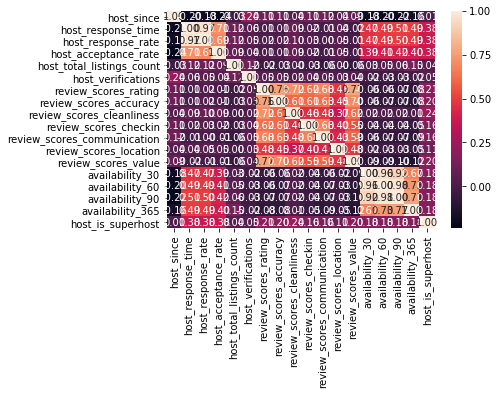

R-Squared Score for our Model is:  0.75308319173





In [2]:
# THREE QUESTIONS TO BE ANSWERED #
#
# 1. For EntireApartment/PrivateRoom/HotelRoom/SharedRoom,
#    What are avg price for different neighbourhoods?
# 2. How correlated are Host Response Behaviour, Host Reviews and Availability
# 3. Predict whether a particular host is a superhost or not?
#
######

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import re
import math
import datetime
print("##### DONE WITH ALL IMPORTS ###### \n\n\n")

# CSV File Paths
SURVEY = os.path.join(os.getcwd(), 'listings.csv')

# Read CSV into Pandas dataframe
df = pd.read_csv(SURVEY)
print("##### DONE WITH CSV IMPORT ###### \n\n\n")


# Get number of rows and columns
def get_rows_columns(df):
    rows = df.shape[0]
    cols = df.shape[1]
    return rows, cols


# Get Cols with No Nulls Values
def no_null_cols(df):
    no_null_col_set = set(df.columns[df.isnull().mean() == 0])
    return no_null_col_set


# Get Cols with Some Null Values (at least one null value)
def some_null_cols(df):
    some_null_col_set = set(df.columns[df.isnull().mean() != 0])
    return some_null_col_set


# Filter Rows based on Value of a column
def filter_rows(df, col_name, val):
    return df[df[col_name] == val]


# Get Value Counts for a Column (how many times a value occurs in a column)
# Returns a pandas series
def get_value_counts(df, col_name):
    return df[col_name].value_counts().reset_index()


# Query Data Set and Group By
# query_string is a String - "Professional == 'Professional developer' and (Gender == 'Male' or Gender == 'Female')"
# group_by is a list - ['Gender', 'FormalEducation']
# mean_by is finalolumn you would like to see - 'Salary'
def query_and_group_by(df, query_string, group_by, mean_by):
    if query_string == "":
        return pd.DataFrame(df.groupby(group_by).mean()[mean_by])
    else:
        return pd.DataFrame(
            df.query(query_string).groupby(group_by).mean()[mean_by]
        )


# Apply a function to a Column
# Returns a Dataframe that can be readily assigned to new column like
# df['new_col_name'] = self.apply_func_to_col(df, col_name, func_name)
def apply_func_to_col(df, col_name, func_name,):
    return df[col_name].apply(func_name)


# Fill NaN with Mean for Numerical Non-Predicting columns
def fill_na_xcols_mean(df, mean_cols):
    return df.apply(lambda col: col.fillna(col.mean())
                    if col.name in mean_cols else col, axis=0)


# Fill NaN with Mean for All columns - Used when we have done dummy fill for
# categorical Columns converting them to Numerical
def fill_na_allcols_mean(df):
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    return df


# Fill NaN with Mode for Categorical Non-Predicting Columns
def fill_na_xcols_mode(df, mode_cols):
    return df.apply(lambda col: col.fillna(col.mode())
                    if col.name in mode_cols else col, axis=0)


# Gets all Categorical Columns
def get_cat_cols(df):
    return df.select_dtypes(include=['object']).copy().columns


# Create Dummy df with extra columns for all values in categorical columns
def create_dummy_df(df, cat_cols, dummy_na):
    for col in cat_cols:
        try:
            df = pd.concat(
                [
                    df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col,
                                                         prefix_sep='_',
                                                         drop_first=True,
                                                         dummy_na=dummy_na)
                ], axis=1
            )
        except:
            continue
    return df


# Drop Unwanted Columns from Dataset
def drop_unwanted_cols(df, cols_lst):
    return df.drop(cols_lst, axis=1)


# To Remove NaN, Split
# X_cols: List of Cols from Dataset we are giving the model to train itself (can be worth multiple columns)
# Y_col: Column from Dataset we want the model to predict (Generally one metric)
# test_size: How much of input we want to reserve as test data for testing out the effectiveness of our fit
#
def drop_and_split(
        df,
        X_cols,
        Y_col,
        test_size=0.30,
        random_state=42,
        unwanted_cols=None,
        mode_cols=None):
    try:
        if X_cols is not None:
            if Y_col is not None:
                total_cols = X_cols + Y_col
                df = df[total_cols]
        if Y_col is None:
            sys.exit("EXITING>>> Predicting Column cannot be null")

        # Removing rows with all missing values for predicting column
        df_dropped = df.dropna(how='any', axis=0, subset=Y_col)
        # Removing columns with all values missing
        df_dropped = df_dropped.dropna(how='all', axis=1)

        Y = df_dropped[Y_col[0]]  # Get Predicting column
        # Drop the predictor Column
        df_dropped = df_dropped.drop(Y_col, axis=1)

        if unwanted_cols is not None:
            df_dropped = drop_unwanted_cols(df_dropped, unwanted_cols)

        # Fill Mode
        if mode_cols is not None:
            df_dropped_and_filled = fill_na_xcols_mode(df_dropped, mode_cols)
        else:
            df_dropped_and_filled = df_dropped

        # Fill Mean
        df_dropped_and_filled = fill_na_allcols_mean(
            df_dropped_and_filled)  # Fill all Columns with Mean

        # Fill Categorical Dummies
        # Get Categorical Columns List
        cat_col_lst = get_cat_cols(df_dropped_and_filled)
        df_dropped_dummy = create_dummy_df(
            df_dropped_and_filled, cat_col_lst, False)  # Fill Dummies Now

        X = df_dropped_dummy
    except:
        sys.exit("EXITING>>> Could not Drop NAs from data set for some reason")

    try:
        X_train, X_test, Y_train, Y_test = train_test_split(
            X, Y, test_size=test_size, random_state=random_state)
        return X_train, X_test, Y_train, Y_test
    except:
        sys.exit(
            "EXITING>>> Could not Split the dropped Dataset")


# To Instantiate, Fit, Predict, Score
def fit_and_predict(X_train, X_test, Y_train, Y_test):
    lm_model = LinearRegression(normalize=True)
    # try:
    lm_model.fit(X_train, Y_train)
    # except:
    #     sys.exit("EXITING>>> Could not Fit the Training Model")
    Y_test_actuals = Y_test
    Y_test_predictions = lm_model.predict(X_test)
    rsquared_score = r2_score(Y_test_actuals, Y_test_predictions)
    return rsquared_score


# To convert Dollars to Numerals
def convert_price_to_number(dol):
    if dol is not None:
        num = re.findall("\$(\d+)", dol)[0]
        return float(num)
    else:
        return None


# To Extract Year from the Date
def extract_year_from_date(date):
    try:
        year = re.findall("\d+", str(date))[0]
        host_for_years = host_since(int(year))
        return host_for_years
    except:
        return None


# To determine Host Since in Number of Years
def host_since(year):
    now = datetime.datetime.now()
    return int(now.year - year)


# To Convert string to array
def convert_string_to_array(verif_array_string):
    if verif_array_string != "[]" and verif_array_string != "None":
        verif_array = re.findall("\'(\w*)\'", verif_array_string)
    else:
        verif_array = []
    return verif_array


# To create response columns based on values in verification_array
def create_verification_array(verif_array, universal_verif_list):
    response = []
    for item in universal_verif_list:
        if item in verif_array:
            response.append(1)
        else:
            response.append(0)
    return pd.Series(response)


# To separate the Host Verifications
def host_verif_pp(verif_array_string):
    universal_verif_list = ['reviews', 'email', 'offline_government_id', 'kba',
                            'selfie', 'government_id', 'identity_manual',
                            'work_email', 'facebook', 'jumio', 'google']
    verif_array = convert_string_to_array(verif_array_string)
    return create_verification_array(verif_array, universal_verif_list)


# To convert the host response time to rating on a scale of 1-10
def convert_response_time_to_rating(val):
    dict_res = {
        "within an hour": 10,
        "within a few hours": 8,
        "within a day": 6,
        "a few days or more": 4,
        "N/A": 1
    }
    try:
        if pd.isnull(val):
            return 1
        else:
            if val in dict_res.keys():
                return dict_res[val]
    except:
        return 1


# Convert percentage to rating
def convert_perc_to_rating(perc):
    try:
        val = re.findall('(\d+)%$', str(perc))[0]
        return int(val)
    except:
        return 0


# To apply a function to col and replace that col with newly created col
def replace_cols(df, col_name, f_name):
    return pd.concat(
        [df.drop(col_name, axis=1), apply_func_to_col(df, col_name, f_name)],
        axis=1
    )


# To get number of verified sources for a host
def num_verif_sources_per_host(val):
    try:
        verif_array = convert_string_to_array(val)
        return len(verif_array)
    except:
        return 0


# To fetch dtype of columns
def print_dtype_cols(df):
    for col in df.columns:
        print(col, df[col].dtype)


# To convert f to 0 and t to 1
def convert_boolean_to_int(val):
    if val is not None:
        if val is 't':
            val = 1
        else:
            val = 0
    return val


# GENERAL HOUSEKEEPING #
# Drop Unwanted Cols from Dataset
unwanted_cols = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'summary', 'space',
    'description', 'neighborhood_overview', 'notes', 'transit', 'access',
    'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url',
    'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_about',
    'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
    'latitude', 'longitude', 'requires_license', 'license',
    'jurisdiction_names', 'experiences_offered'
]
df = drop_unwanted_cols(df, unwanted_cols)

# Total Columns After Dropping
rows, cols = get_rows_columns(df)
print("Number of Columns after dropping unwanted cols are: ", cols)
print("\n\n")

# Columns will no null values
no_null_col_set = no_null_cols(df)
print("Columns with No Nulls are: ", no_null_col_set, "\n")
print("Number of Cols with No Nulls are: ", len(no_null_col_set))
print("\n\n")

# Snapshot of df to start with at the beginning of each question
df_orig = df
###########################


# QUESTION 1 #
df = df_orig

# Group and Find the Mean
df = replace_cols(df, 'price', convert_price_to_number)
grouped_data_price = query_and_group_by(
    df, "", ['room_type', 'neighbourhood_group_cleansed'], 'price')
print("Grouped and Meaned Data is:\n", grouped_data_price)
print("\n\n")
###########################


# QUESTION 2 #
df = df_orig
df = replace_cols(df, 'host_since', extract_year_from_date)
df = replace_cols(df, 'host_response_time', convert_response_time_to_rating)
df = replace_cols(df, 'host_response_rate', convert_perc_to_rating)
df = replace_cols(df, 'host_acceptance_rate', convert_perc_to_rating)
df = replace_cols(df, 'host_verifications', num_verif_sources_per_host)
df = replace_cols(df, 'host_is_superhost', convert_boolean_to_int)


wanted_cols = [
    'host_since', 'host_response_time', 'host_response_rate',
    'host_acceptance_rate', 'host_total_listings_count', 'host_verifications',
    'review_scores_rating', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'availability_30', 'availability_60',
    'availability_90', 'availability_365', 'host_is_superhost'
]
df_subset = df[wanted_cols]
hm = sns.heatmap(df_subset.corr(), annot=True, fmt=".2f")
plt.show()

###
# Conclusion for Question 2
# 1. We were expecting that host_response_time and host_response_rate would have a positive
#    corelation with the review_score_communication but found otherwise
# 2. Reviews and Availability have negative correlation which is expecting as properties with higher
#    review rating are expected to be booked more
# 3. We were also expecting that host_reponse_* will have a negative correlation with availability
#    but turened out to be otherwise
# 4. Expected: Reviews of all aspects are highly correlated and go hand-in-hand
# 5. Unexpected: Number of years as host has low negative correlation with response time, response rate
#    and acceptance rate
####
###########################


# QUESTION 3 #
df = df_orig
df = replace_cols(df, 'host_since', extract_year_from_date)
df = replace_cols(df, 'host_response_time', convert_response_time_to_rating)
df = replace_cols(df, 'host_response_rate', convert_perc_to_rating)
df = replace_cols(df, 'host_acceptance_rate', convert_perc_to_rating)
df = replace_cols(df, 'host_verifications', num_verif_sources_per_host)
df = replace_cols(df, 'price', convert_price_to_number)
df = replace_cols(df, 'host_is_superhost', convert_boolean_to_int)
df = replace_cols(df, 'host_identity_verified', convert_boolean_to_int)
df = replace_cols(df, 'host_has_profile_pic', convert_boolean_to_int)
df = replace_cols(df, 'has_availability', convert_boolean_to_int)
df = replace_cols(df, 'instant_bookable', convert_boolean_to_int)
df = replace_cols(df, 'is_business_travel_ready', convert_boolean_to_int)
df = replace_cols(df, 'require_guest_profile_picture', convert_boolean_to_int)
df = replace_cols(df, 'require_guest_phone_verification',
                  convert_boolean_to_int)

wanted_X_cols = [
    'host_response_time', 'host_response_rate', 'host_acceptance_rate',
    'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'review_scores_accuracy', 'availability_30',
    'availability_60', 'availability_90', 'availability_365',
    'cancellation_policy', 'neighbourhood_group_cleansed', 'room_type',
    'price', 'bathrooms', 'bedrooms', 'beds', 'host_verifications',
    'host_listings_count', 'host_total_listings_count',
    'host_identity_verified', 'host_has_profile_pic', 'accommodates',
    'bed_type', 'guests_included', 'minimum_nights', 'maximum_nights',
    'minimum_minimum_nights', 'maximum_minimum_nights',
    'minimum_maximum_nights', 'maximum_maximum_nights',
    'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
    'number_of_reviews', 'number_of_reviews_ltm', 'instant_bookable',
    'is_business_travel_ready', 'require_guest_profile_picture',
    'require_guest_phone_verification', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
    'square_feet'
]

wanted_Y_col = ['review_scores_rating']

X_train, X_test, Y_train, Y_test = drop_and_split(
    df, wanted_X_cols, wanted_Y_col)
rsquared_score = fit_and_predict(X_train, X_test, Y_train, Y_test)
print("R-Squared Score for our Model is: ", rsquared_score)
print("\n\n")


###
# Conclusion for Question 3
# 1. review_scores_rating: 0.75 r_squared
# 2. price: 0.39 r_squared
# 3. host_is_superhost: 0.29
####
###########################


# OPTIONAL CODE #
# universal_verif_list = ['reviews', 'email', 'offline_government_id', 'kba', 'selfie', 'government_id', 'identity_manual', 'work_email', 'facebook', 'jumio', 'google']
# df_subset[universal_verif_list] = df['host_verifications'].apply(host_verif_pp)
###########################
